In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset


In [3]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
X = df.drop(columns=["Class"])
y = df["Class"]

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

In [7]:
X_normal = X_tensor[y_tensor == 0]
X_fraud = X_tensor[y_tensor == 1]

In [8]:
X_train, X_test = train_test_split(X_normal, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(X_train), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test), batch_size=128)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=30, latent_dim=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.mu = nn.Linear(8, latent_dim)
        self.logvar = nn.Linear(8, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 8)
        self.fc4 = nn.Linear(8, 16)
        self.fc5 = nn.Linear(16, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        return self.fc5(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [10]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        recon, mu, logvar = model(x)
        loss = vae_loss(recon, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 28.6391
Epoch 2, Loss: 27.9464
Epoch 3, Loss: 26.6546
Epoch 4, Loss: 25.7977
Epoch 5, Loss: 25.3947
Epoch 6, Loss: 25.1294
Epoch 7, Loss: 24.9379
Epoch 8, Loss: 24.7882
Epoch 9, Loss: 24.6898
Epoch 10, Loss: 24.4920
Epoch 11, Loss: 24.2828
Epoch 12, Loss: 24.1720
Epoch 13, Loss: 24.0840
Epoch 14, Loss: 23.8248
Epoch 15, Loss: 23.5978
Epoch 16, Loss: 23.5120
Epoch 17, Loss: 23.4367
Epoch 18, Loss: 23.3755
Epoch 19, Loss: 23.3288
Epoch 20, Loss: 23.2749


In [12]:
from torch.utils.data import TensorDataset, DataLoader
X_eval = torch.cat([X_test, X_fraud])
y_eval = torch.cat([torch.zeros(len(X_test)), torch.ones(len(X_fraud))])
eval_loader = DataLoader(TensorDataset(X_eval, y_eval), batch_size=128)


In [13]:
model.eval()
recon_errors = []
true_labels = []

with torch.no_grad():
    for batch in eval_loader:
        x, labels = batch
        x = x.to(device)
        recon, mu, logvar = model(x)
        error = F.mse_loss(recon, x, reduction='none').mean(dim=1)
        recon_errors.extend(error.cpu().numpy())
        true_labels.extend(labels.numpy())


In [14]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report

recon_errors = np.array(recon_errors)
true_labels = np.array(true_labels)

# ROC-AUC Score
roc_auc = roc_auc_score(true_labels, recon_errors)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# PR-AUC Score
precision, recall, _ = precision_recall_curve(true_labels, recon_errors)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")


ROC-AUC Score: 0.9327
Precision-Recall AUC: 0.5156


In [ ]:
threshold = np.percentile(recon_errors[true_labels == 0], 95)
print(f"Threshold: {threshold:.4f}")

# Predictions
preds = (recon_errors > threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, preds))


Threshold: 1.4097
Confusion Matrix:
[[54019  2844]
 [   75   417]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97     56863
         1.0       0.13      0.85      0.22       492

    accuracy                           0.95     57355
   macro avg       0.56      0.90      0.60     57355
weighted avg       0.99      0.95      0.97     57355



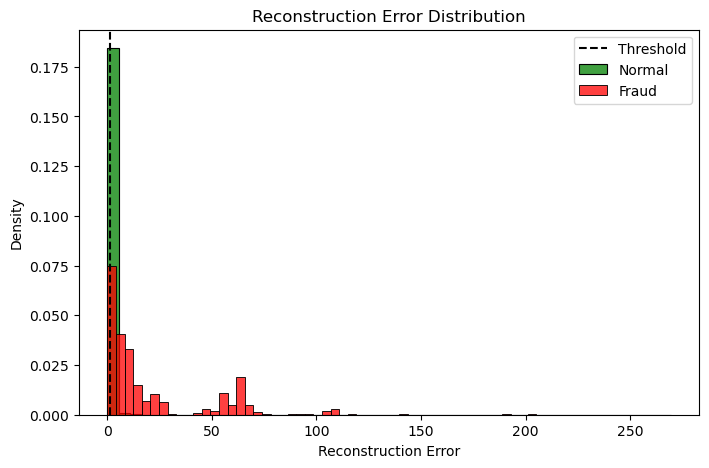

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(recon_errors[true_labels == 0], bins=50, color='green', label="Normal", stat='density')
sns.histplot(recon_errors[true_labels == 1], bins=50, color='red', label="Fraud", stat='density')
plt.axvline(threshold, color='black', linestyle='--', label="Threshold")
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.legend()
plt.show()
